In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
from matplotlib import rcParams
import seaborn as sns


style.use('ggplot')
rcParams['figure.figsize'] = (8.0, 8.0)

# Task 2.1

In [2]:
'''
Defining the function f and implementing the OneStep pseudocode
'''

def f(z,x,y,beta,b):
    '''
    Using the definition for f given in the notes
    '''
    vec = np.dot(z,np.transpose(x))
    mult = np.multiply(beta,y)
    return np.sum(np.multiply(mult,vec)) + b 

def OneStep(i,j,x,y,beta,b,C):
    beta,b = beta,b
    
    '''
    Computing delta, s, chi and gamma as defined and updating the values of beta[i] and beta[j] as described
    '''
    
    delta = y[i]*((f(x[j],x,y,beta,b)-y[j]) - (f(x[i],x,y,beta,b)-y[i]))
    s = y[i]*y[j]
    chi = np.dot(x[i],x[i]) + np.dot(x[j],x[j]) - 2*np.dot(x[i],x[j])
    gamma = s*beta[i] + beta[j]
    
    if s == 1:
        L = max(0,gamma-C)
        H = min(gamma,C)
        
    else:
        L = max(0,-gamma)
        H = min(C,C-gamma)
        
    
    if chi > 0:
        beta[i] = min(max(beta[i]+delta/chi,L),H)
    elif delta > 0:
        beta[i] = L
    else:
        beta[i] = H
        
    beta[j] = gamma - s*beta[i]
    
    b = b - 0.5*(f(x[i],x,y,beta,b) - y[i] + f(x[j],x,y,beta,b) - y[j])
    
    return (beta,b)

# Task 2.2

In [3]:
'''
Creating 20 2-dimensional exponential random values with parameter 4 and concatenating those values with another
20 2-dimensional exponential random values with parameter 0.5.

Afterwards, assigning label -1 to the first 20 and 1 to the rest of them
'''

x = np.random.exponential(4,size = (20,2))
x = np.concatenate((x,np.random.exponential(0.5,size = (20,2))))

y = np.concatenate((-np.ones(20),np.ones(20)))

# Task 2.3

In [4]:
'''
Implementing the described algorithm for support vector machines
'''

def SMO(x,y,C,iterations = 10000):
    
    '''
    Initializing with beta being the vector 0 and b being the scalar 0
    '''
    beta,b = np.zeros(len(x)),0
    
    for it in range(iterations):
        
        '''
        Choosing random entry values for i and j and changing j in case it is equal to i.
        Afterwards, using the OneStep algorithm
        '''
        i,j = np.random.choice(len(beta),2)
        while i == j:
            j = np.random.choice(len(beta))
            
        beta,b = OneStep(i,j,x,y,beta,b,C)
        
    '''
    Selecting the marginal beta values, computing their mean and updating b as described in the algorithm
    '''
    p,q = 0,1e-16
    
    for entry in range(len(beta)):
        if beta[entry] > 0 and beta[entry] < C:
            p += f(x[entry],x,y,beta,b) - y[entry]
            q += 1
            
    b = b - p/q
    
    return (beta,b)

In [5]:
'''
Using the function we defined to try out its performance on several values for C.

Storing the computed betas and bs to use them later
'''

Cs = [0.01,1,100]
betas,bs = [],[]

for C in Cs:
    beta,b = SMO(x,y,C)
    betas.append(beta)
    bs.append(b)

## c)

In [6]:
'''
Use the LLS algorithm in the built data set. We used the same code as in the first sheet: we add and extra entry
to each point in our data set and solving the least squares problem as a system of linear equations,
being alpha the solution
'''
x_mod = np.concatenate((np.expand_dims(np.ones(len(x)),-1),x),axis=1)

A,B = np.dot(np.transpose(x_mod),x_mod),np.dot(np.transpose(x_mod),y)
alpha = np.dot(np.linalg.inv(A),B)

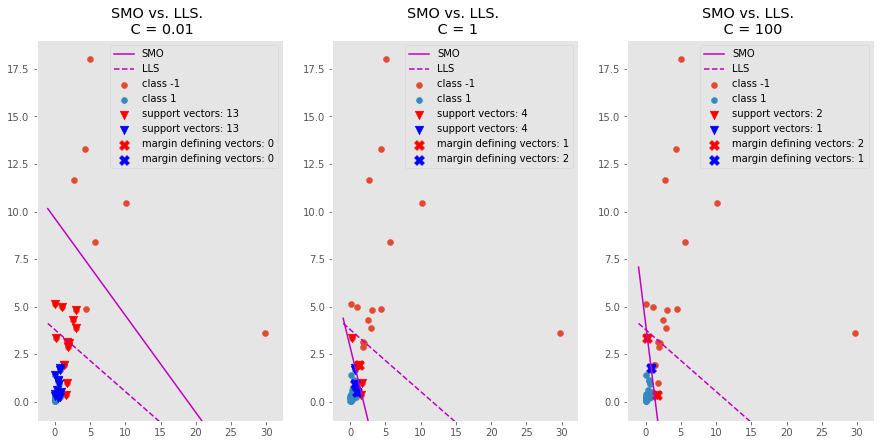

In [7]:
'''
Plotting different support vector machines we got for different values of C and comparing the
result with the performance of LLS
'''

fig,axs = plt.subplots(nrows=1, ncols=3,figsize=(15,7))
plt.title("SMO vs. LLS")

for entry in range(len(Cs)):
    
    '''
    Picking the minimum and maximum on the first entries or each point of our data set. 
    
    We will use this to plot the lines obtained with the LLS and SVM algorithms by computing y_min, y_max, 
    y_min_LLS and y_max_LLS as the solutions of the equation alpha1*x + alpha2*y + b = 0
    '''
    x_min,x_max = min(x[...,0])-1,max(x[...,0])+1
    alpha1,alpha2 = np.sum(betas[entry]*y*x[...,0]),np.sum(betas[entry]*y*x[...,1])

    y_min,y_max = -(bs[entry]+alpha1*x_min)/alpha2,-(bs[entry]+alpha1*x_max)/alpha2
    y_min_LLS,y_max_LLS = -(alpha[0]+alpha[1]*x_min)/alpha[2],-(alpha[0]+alpha[1]*x_max)/alpha[2]
    
    '''
    Computing the support and margin vectors according to the definition depending on the values of beta.
    We separate them by classes just for plotting them following the color code.
    We also compute the amount of them as requested and will be printed in the legend of the plots.
    
    The way we select the support and margin vectors is by definition and using vectorization on beta
    '''

    support_vectors_r = x[:20][betas[entry][:20] > 0]
    support_vectors_b = x[20:][betas[entry][20:] > 0]
    spr,spb = str(len(support_vectors_r)),str(len(support_vectors_b))
    
    margin_r = x[:20][np.logical_and(betas[entry][:20] > 0,betas[entry][:20] < Cs[entry])]
    margin_b = x[20:][np.logical_and(betas[entry][20:] > 0,betas[entry][20:] < Cs[entry])]
    mr = str(len(margin_r))
    mb = str(len(margin_b))
    
    '''
    Plotting points and requested lines
    '''

    axs[entry].scatter(x[...,0][:20],x[...,1][:20],label = "class -1")
    axs[entry].scatter(x[...,0][20:],x[...,1][20:],label = "class 1")
    axs[entry].scatter(support_vectors_r[...,0],support_vectors_r[...,1],color = "r",marker = "v",s=75,label = "support vectors: " + spr)
    axs[entry].scatter(support_vectors_b[...,0],support_vectors_b[...,1],color = "b",marker = "v",s=75,label = "support vectors: " + spb)
    axs[entry].scatter(margin_r[...,0],margin_r[...,1],color = "r",marker = "X",s=100,label = "margin defining vectors: "+mr)
    axs[entry].scatter(margin_b[...,0],margin_b[...,1],color = "b",marker = "X",s=100,label = "margin defining vectors: "+mb)
    
    axs[entry].plot([x_min,x_max],[y_min,y_max],"m-",label = "SMO")
    axs[entry].plot([x_min,x_max],[y_min_LLS,y_max_LLS],"m--",label = "LLS")
    axs[entry].set_ylim([-1,max(x[...,1])+1])
    axs[entry].legend(loc = 1)
    axs[entry].grid(False)
    axs[entry].set_title("SMO vs. LLS. \n C = "+str(Cs[entry]))
    
plt.show()

<h5>The bigger the value of C is, the less error margin it gives for the classification.</h5>

<h5>Also, the bigger C is, the less support and margin defining vectors we have </h5>

# Task 2.4

In [8]:
'''
Building a test data set in the same fashion as the original data set, namely 1000 points following an exponential
distribution of parameter 4 with label -1 and 1000 points with an exponential law with parameter 0.5 and label 1
'''

x_test = np.random.exponential(4,size = (1000,2))
x_test = np.concatenate((x_test,np.random.exponential(0.5,size = (1000,2))))

y_test = np.concatenate((-np.ones(1000),np.ones(1000)))

'''
Computed to compare the results from LLS and SVM. We are appling the map (x,y) \rightarrow (1,x,y)
to each point in our data set
'''
    
x_mod_test = np.concatenate((np.expand_dims(np.ones(len(x_test)),-1),x_test),axis=1)

In [9]:
'''
Computing the accuracy of the LLS on the test data set.

We compute the dot product our LLS solution (alpha) with the first 1000 points in our test data set 
and check how many of them are smaller or equal than 0.5 since that is the division line.
Then we compute the dot product between alpha and the last 1000 points in our test data set and check how many
results bigger than 0.5.

We sum those two number and divide it by the size of our test data set
'''

cn = np.sum(np.sum(np.multiply(alpha,x_mod_test[:1000]),axis=1) <= 0.5)
cp = np.sum(np.sum(np.multiply(alpha,x_mod_test[1000:]),axis=1) > 0.5)

print("Acuracy of LLS: ",(cp+cn)/len(x_test))

Acuracy of LLS:  0.533


In [10]:
'''
Computing the accuracy of our SVM using several values of C on our test data set.

For each of the values of C, we apply the f function to each point in our test data set and multiply it by the 
actual label. If that number if positive, it means the classification was accurate and count it in the "ac" variable.
Then we divide the value of ac over the size of the test data set and we take that as the accuracy.

We store the accuracies in "accs" for plotting them later
'''

accs = []
for C in range(len(Cs)):
    ac = 0
    for i in range(len(x_test)):
        ac += (f(x_test[i],x,y,betas[C],bs[C])*y_test[i] > 0)
        
    accs.append(ac)
        
    print("Accuracy of SMO using C = " +str(Cs[C])+":",ac/len(x_test))

Accuracy of SMO using C = 0.01: 0.589
Accuracy of SMO using C = 1: 0.9245
Accuracy of SMO using C = 100: 0.907


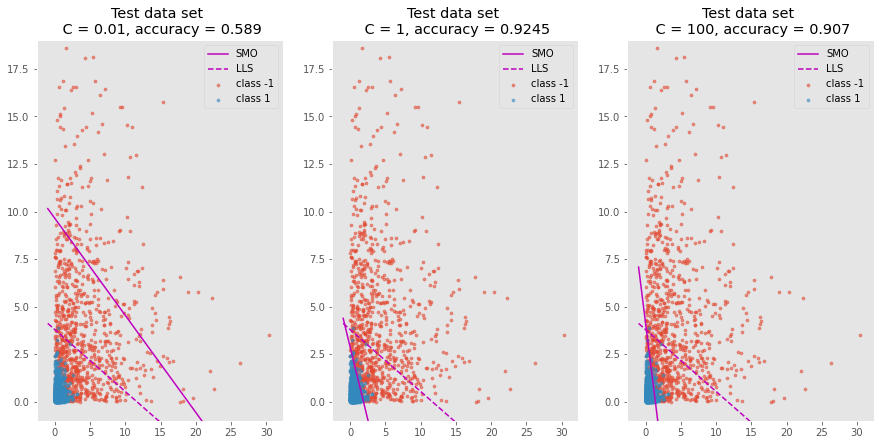

In [11]:
'''
We plot the results for the different values of C we took
'''

fig,axs = plt.subplots(nrows=1, ncols=3,figsize=(15,7))
plt.title("SMO vs. LLS")

for entry in range(len(Cs)):
    '''
    Same as before, we take the minimum and maximum first entries in our test data set and compute
    the lines we had before
    '''
    
    x_min,x_max = min(x[...,0])-1,max(x[...,0])+1
    alpha1,alpha2 = np.sum(betas[entry]*y*x[...,0]),np.sum(betas[entry]*y*x[...,1])

    y_min,y_max = -(bs[entry]+alpha1*x_min)/alpha2,-(bs[entry]+alpha1*x_max)/alpha2
    y_min_LLS,y_max_LLS = -(alpha[0]+alpha[1]*x_min)/alpha[2],-(alpha[0]+alpha[1]*x_max)/alpha[2]

    axs[entry].scatter(x_test[...,0][:1000],x_test[...,1][:1000],label = "class -1",s=10,alpha = 0.6)
    axs[entry].scatter(x_test[...,0][1000:],x_test[...,1][1000:],label = "class 1",s=10,alpha = 0.6)

    axs[entry].plot([x_min,x_max],[y_min,y_max],"m-",label = "SMO")
    axs[entry].plot([x_min,x_max],[y_min_LLS,y_max_LLS],"m--",label = "LLS")
    axs[entry].set_ylim([-1,max(x[...,1])+1])
    axs[entry].legend(loc = 1)
    axs[entry].grid(False)
    axs[entry].set_title("Test data set \n C = "+str(Cs[entry])+", accuracy = " +str(accs[entry]/len(x_test)))
    
plt.show()

# Task 2.5

In [12]:
'''
Defining a svm using the KKT way or choosing entries
'''

def SMO_KKT(C,iterations = 10000):
    
    '''
    Initializing with beta being the vector 0 and b being the scalar 0
    '''
    beta,b = np.zeros(len(x)),0
    
    '''
    Computing the values of KKT according to the definition and starting the iterations
    '''
    
    KKT = []
    for i in range(len(beta)):
        v1 = (C-beta[i])*max(0,1-y[i]*f(x[i],x,y,beta,b))
        v2 = beta[i]*max(0,y[i]*f(x[i],x,y,beta,b)-1)
        KKT.append(v1 + v2)
            
    for it in range(iterations):
        
        '''
        If all entries in KKT are 0, we stop iterating. Otherwise, we take a random positive
        entry of beta and call it i
        '''    
        if np.sum(np.array(KKT) != 0) == 0:
            break
        else:
            i = np.random.choice(len(beta))
        
        if KKT[i] <= 0:
            continue
            
        '''
        We search for the entries in beta which are between 0 and C without considering i.
        If there is any option left, we randomly choose one value out of that set.
        If not, we choose randomly one entry of beta
        '''
        options = np.where(np.logical_and(np.array(beta) >0,np.array(beta) < C))[0]
        options = np.setdiff1d(options,[i])
        if len(options) > 0:
            j = np.random.choice(options)
            while i == j:
                j = np.random.choice(options)
                
        else:
            j = np.random.choice(len(beta))
            while i == j:
                j = np.random.choice(len(beta))
                
        '''
        We use the OneStep algoritm on entries i and j
        '''
        beta,b = OneStep(i,j,x,y,beta,b,C)
        
        '''
        Since the OneStep algorithm applied over the entries i and j only involves and changes the values of 
        beta[i] and beta[j], we do not need not compute every KKT value all over again. It is enough to compute
        the ith and jth entry using the new beta and b.
        
        This is done for reducing the computing time
        '''
        v1 = (C-beta[i])*max(0,1-y[i]*f(x[i],x,y,beta,b))
        v2 = beta[i]*max(0,y[i]*f(x[i],x,y,beta,b)-1)
        KKT[i] = v1 + v2
        
        v1 = (C-beta[j])*max(0,1-y[j]*f(x[j],x,y,beta,b))
        v2 = beta[j]*max(0,y[j]*f(x[j],x,y,beta,b)-1)
        KKT[j] = v1 + v2
        
        
    '''
    Same ending as in the SMO function
    '''
    p,q = 0,1e-16
    
    for entry in range(len(beta)):
        if beta[entry] > 0 and beta[entry] < C:
            p += f(x[entry],x,y,beta,b) - y[entry]
            q += 1
            
    b = b - p/q
    
    return (beta,b)

In [13]:
'''
Computing time of processing as the average of 10 iterations using different values of C and realizing 
the KKT algorithm makes the program 10 times faster
'''

from time import time

times,times_kkt = [],[]

for it in range(10):

    Cs = [0.01,1,100]
    betas,bs = [],[]

    for C in Cs:
        T = time()
        beta,b = SMO(x,y,C)
        times.append(time()-T)
        betas.append(beta)
        bs.append(b)
    
print("Randomly choosing took ", np.mean(times), " seconds")

for it in range(10):
    Cs = [0.01,1,100]
    betas_kkt,bs_kkt = [],[]

    for C in Cs:
        T = time()
        beta,b = SMO_KKT(C)
        times_kkt.append(time()-T)
        betas_kkt.append(beta)
        bs_kkt.append(b)
    
print("Using the KKT algorithm took ", np.mean(times_kkt), " seconds")

Randomly choosing took  0.9801294008890787  seconds
Using the KKT algorithm took  0.048996774355570476  seconds


<h5>The KKT heuristic makes the algorithm much more faster (more than 10 times faster).</h5>

May be worthy to say we computed the time this way instead of using the %timeit function so we could average over different values of C as well

In [14]:
'''
Computing the accuracy of the KKT algorithm in the same fashion as before and saving them in accs_kkt
'''

Cs = [0.01,1,100]
betas_kkt,bs_kkt = [],[]
for C in Cs:
    beta,b = SMO_KKT(C)
    betas_kkt.append(beta)
    bs_kkt.append(b)

accs_kkt = []
for C in range(len(Cs)):
    ac = 0
    for i in range(len(x_test)):
        ac += (f(x_test[i],x,y,betas_kkt[C],bs_kkt[C])*y_test[i] > 0)
        
    accs_kkt.append(ac)
        
    print("Accuracy of SMO and KKT using C = " +str(Cs[C])+":",ac/len(x_test))

Accuracy of SMO and KKT using C = 0.01: 0.813
Accuracy of SMO and KKT using C = 1: 0.867
Accuracy of SMO and KKT using C = 100: 0.877


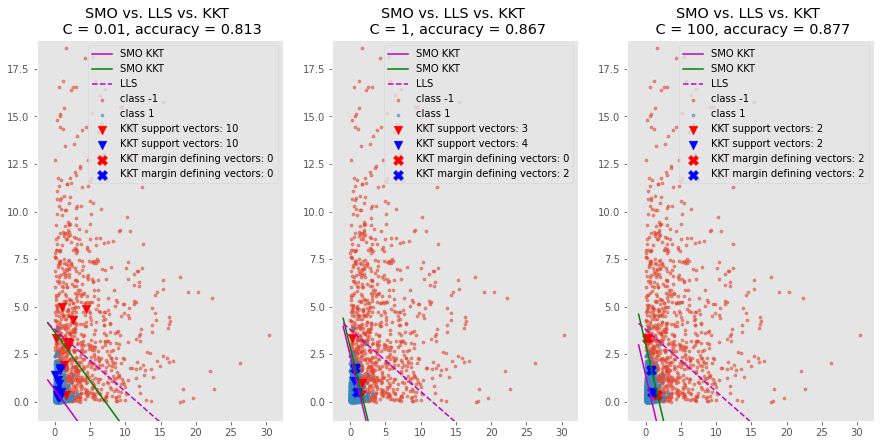

In [15]:
'''
Plots comparing SMO, LLS and KKT algorithms.

The way it is done is completely analogous as without the KKT algorithm, but in this case, the 
support and margin vectors are computed for the KKT algorithm instead.
'''

fig,axs = plt.subplots(nrows=1, ncols=3,figsize=(15,7))
plt.title("SMO vs. LLS vs. KKT")

for entry in range(len(Cs)):
    x_min,x_max = min(x[...,0])-1,max(x[...,0])+1
    alpha1,alpha2 = np.sum(betas[entry]*y*x[...,0]),np.sum(betas[entry]*y*x[...,1])
    alpha1_kkt,alpha2_kkt = np.sum(betas_kkt[entry]*y*x[...,0]),np.sum(betas_kkt[entry]*y*x[...,1])

    y_min,y_max = -(bs[entry]+alpha1*x_min)/alpha2,-(bs[entry]+alpha1*x_max)/alpha2
    y_min_kkt,y_max_kkt = -(bs_kkt[entry]+alpha1*x_min)/alpha2,-(bs_kkt[entry]+alpha1*x_max)/alpha2
    y_min_LLS,y_max_LLS = -(alpha[0]+alpha[1]*x_min)/alpha[2],-(alpha[0]+alpha[1]*x_max)/alpha[2]

    support_vectors_r = x[:20][betas_kkt[entry][:20] > 0]
    support_vectors_b = x[20:][betas_kkt[entry][20:] > 0]
    spr,spb = str(len(support_vectors_r)),str(len(support_vectors_b))
    
    margin_r = x[:20][np.logical_and(betas_kkt[entry][:20] > 0,betas_kkt[entry][:20] < Cs[entry])]
    margin_b = x[20:][np.logical_and(betas_kkt[entry][20:] > 0,betas_kkt[entry][20:] < Cs[entry])]
    mr = str(len(margin_r))
    mb = str(len(margin_b))

    axs[entry].scatter(x_test[...,0][:1000],x_test[...,1][:1000],label = "class -1",s=10,alpha = 0.6)
    axs[entry].scatter(x_test[...,0][1000:],x_test[...,1][1000:],label = "class 1",s=10,alpha = 0.6)
    
    axs[entry].scatter(support_vectors_r[...,0],support_vectors_r[...,1],color = "r",marker = "v",s=75,label = "KKT support vectors: " + spr)
    axs[entry].scatter(support_vectors_b[...,0],support_vectors_b[...,1],color = "b",marker = "v",s=75,label = "KKT support vectors: " + spb)
    axs[entry].scatter(margin_r[...,0],margin_r[...,1],color = "r",marker = "X",s=100,label = "KKT margin defining vectors: "+mr)
    axs[entry].scatter(margin_b[...,0],margin_b[...,1],color = "b",marker = "X",s=100,label = "KKT margin defining vectors: "+mb)
    

    axs[entry].plot([x_min,x_max],[y_min_kkt,y_max_kkt],"m-",label = "SMO KKT")
    axs[entry].plot([x_min,x_max],[y_min,y_max],"g-",label = "SMO KKT")
    axs[entry].plot([x_min,x_max],[y_min_LLS,y_max_LLS],"m--",label = "LLS")
    axs[entry].set_ylim([-1,max(x[...,1])+1])
    axs[entry].legend(loc = 1)
    axs[entry].grid(False)
    axs[entry].set_title("SMO vs. LLS vs. KKT \n C = "+str(Cs[entry])+", accuracy = " +str(accs_kkt[entry]/len(x_test)))
    
plt.show()

# Task 2.6

In [16]:
'''
Generating random values inside the circle.

We generated 100 random angles between 0 and 2pi, 50 random radius between 0 and 1 first and
50 random radius between 1 and 2. Then we used the usual change of variables to express our points in 
cartesian coordinates.

Lastly, we assigned the label -1 to the first 50 points and 1 to the rest of them.
'''

radius,angle = np.random.uniform(0,1,50),np.random.uniform(0,2*np.pi,50)
x = np.transpose([np.multiply(radius,np.cos(angle)),np.multiply(radius,np.sin(angle))])

radius,angle = np.random.uniform(1,2,50),np.random.uniform(0,2*np.pi,50)
x1 = np.transpose([np.multiply(radius,np.cos(angle)),np.multiply(radius,np.sin(angle))])

x = np.concatenate((x,x1))
y = np.concatenate((-np.ones(50),np.ones(50)))

## a) 

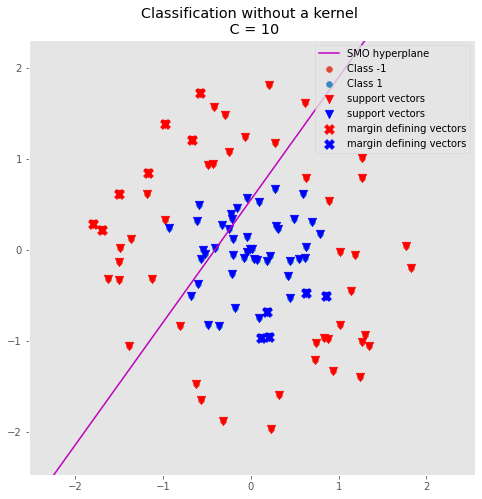

In [17]:
'''
Applying the smv with C = 10 to the generated data and plotting the results.
We used the same code as in previous tasks.
'''

beta,b = SMO(x,y,10)

support_vectors_r = x[int(len(x)/2):][beta[int(len(x)/2):] > 0]
support_vectors_b = x[:int(len(x)/2)][beta[:int(len(x)/2)] > 0]

margin_r = x[int(len(x)/2):][np.logical_and(beta[int(len(x)/2):] > 0,beta[int(len(x)/2):] < 10)]
margin_b = x[:int(len(x)/2)][np.logical_and(beta[:int(len(x)/2)] > 0,beta[:int(len(x)/2)] < 10)]

plt.scatter(x[...,0][int(len(y)/2):],x[...,1][int(len(y)/2):],label = "Class -1")
plt.scatter(x[...,0][:int(len(y)/2)],x[...,1][:int(len(y)/2)],label = "Class 1")

plt.scatter(support_vectors_r[...,0],support_vectors_r[...,1],color = "r",marker = "v",s=75,label = "support vectors")
plt.scatter(support_vectors_b[...,0],support_vectors_b[...,1],color = "b",marker = "v",s=75,label = "support vectors")
plt.scatter(margin_r[...,0],margin_r[...,1],color = "r",marker = "X",s=100,label = "margin defining vectors")
plt.scatter(margin_b[...,0],margin_b[...,1],color = "b",marker = "X",s=100,label = "margin defining vectors")


x_min,x_max = min(x[...,0])-0.5,max(x[...,0])+0.5
alpha1,alpha2 = np.sum(beta*y*x[...,0]),np.sum(beta*y*x[...,1])

y_min,y_max = -(b+alpha1*x_min)/alpha2,-(b+alpha1*x_max)/alpha2

plt.plot([x_min,x_max],[y_min,y_max],"m-",label = "SMO hyperplane")
plt.ylim([min(x[...,1])-0.5,max(x[...,1])+0.5])
plt.legend(loc = 1)
plt.grid(False)
plt.title("Classification without a kernel \n C = 10")
    
plt.show()

## b)

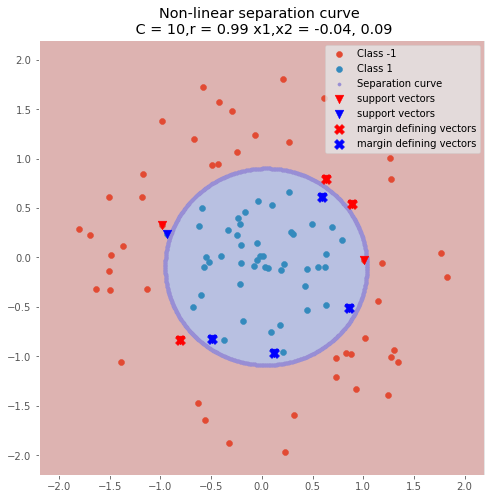

In [18]:
'''
Using the transformation phi on each point of our data set and using the SMO function
'''

x_trans = np.sum(np.power(x,2),axis = 1)
phi = np.transpose(np.stack([x[...,0],x[...,1],x_trans]))

beta_phi,b_phi = SMO(phi,y,10)

'''
Analytically solving the equation in which the function f vanishes and plotting it as the separation curve
'''

alpha1,alpha2 = np.sum(beta_phi*y*x[...,0]),np.sum(beta_phi*y*x[...,1])
alpha3 = np.sum(beta_phi*y*np.power(x[...,0],2)) + np.sum(beta_phi*y*np.power(x[...,1],2))
r = np.sqrt((alpha1**2+alpha2**2)/(4*(alpha3**2)) - b_phi/alpha3)
x1,x2 = alpha1/(2*alpha3),alpha2/(2*alpha3)

sep_curve = np.linspace(0,2*np.pi,1000)
sep_curve = r*np.transpose([np.cos(sep_curve) - x1,np.sin(sep_curve) - x2])

'''
Creating a mesh on our region of interest in order to numerically search the points in which  vanishes.
To do so, once we have our mesh, we just apply our classification function to each one of its points
'''

xx2, yy2 = np.meshgrid(np.arange(-2.2, 2.2, .01),
                     np.arange(-2.2, 2.2, .01))

mesh = np.c_[xx2.ravel(), yy2.ravel()]
mesh = np.concatenate((mesh,np.expand_dims(np.sum(np.power(mesh,2),axis=1),-1)),axis=1)
M = []

for m in mesh:
    M.append(np.sum(np.multiply(beta_phi,np.multiply(y,np.dot(phi,m)))) +b_phi > 0)


mesh = np.array(M).reshape(xx2.shape)

'''
Compute the support and margin vectors
'''

support_vectors_r = x[int(len(x)/2):][beta_phi[int(len(x)/2):] > 0]
support_vectors_b = x[:int(len(x)/2)][beta_phi[:int(len(x)/2)] > 0]

margin_r = x[int(len(x)/2):][np.logical_and(beta_phi[int(len(x)/2):] > 0,beta_phi[int(len(x)/2):] < 10)]
margin_b = x[:int(len(x)/2)][np.logical_and(beta_phi[:int(len(x)/2)] > 0,beta_phi[:int(len(x)/2)] < 10)]

'''
Plot the data set, the support and margin vectors, the analytical solution for the separation curve
and giving the background different colors to visualize the numerical solution
'''

plt.contourf(xx2, yy2, mesh, cmap=plt.cm.coolwarm, alpha=0.3)
plt.scatter(phi[...,0][int(len(y)/2):],phi[...,1][int(len(y)/2):],label = "Class -1")
plt.scatter(phi[...,0][:int(len(y)/2)],phi[...,1][:int(len(y)/2)],label = "Class 1")
plt.scatter(sep_curve[...,0],sep_curve[...,1],s = 10,label = "Separation curve")

plt.scatter(support_vectors_r[...,0],support_vectors_r[...,1],color = "r",marker = "v",s=75,label = "support vectors")
plt.scatter(support_vectors_b[...,0],support_vectors_b[...,1],color = "b",marker = "v",s=75,label = "support vectors")
plt.scatter(margin_r[...,0],margin_r[...,1],color = "r",marker = "X",s=100,label = "margin defining vectors")
plt.scatter(margin_b[...,0],margin_b[...,1],color = "b",marker = "X",s=100,label = "margin defining vectors")

    
plt.ylim([-2.2,2.2])
plt.xlim([-2.2,2.2])
plt.legend(loc = 1)
plt.grid(False)
plt.title("Non-linear separation curve \n C = 10,r = "+str(int(100*r)/100)+" x1,x2 = "+str(int(100*x1)/100)+", "+str(int(100*x2)/100))
plt.show()


On the previuos plot, we calculated the analytical solution for the place in which the function f vanishes. To do so, we solved <center><h3>$\alpha_1 z_1 + \alpha_2z_2 + \alpha_3 z_3 +b = 0$,<h3/></center> where <center><h3>$\alpha_3 = \phi(\alpha_1,\alpha_2) = \alpha_1 ^2 + \alpha_2^2$</h3></center> and <h3><center>$z_3 = \phi(z_1,z_2) = z_1 ^2 + z_2^2$, </h3></center> which is clearly a circle.
    
Putting it in the canonical shape, we have <center><h3>$\left(z_1+\frac{\alpha_1}{2\alpha_3}\right)^2+\left(z_2+\frac{\alpha_2}{2\alpha_3}\right)^2 = \frac{\alpha_1^2+\alpha_2^2}{4\alpha_3^2} - \frac{b}{\alpha_3}$</h3></center>

<h5>What the $\varphi$ function does is embedding the data set into $\mathbb{R}^3$ in such way that the plane $z = 1$ separates the data, so now a proper beta and b can be computed.  </h5>

# Task 2.7

In [19]:
'''
Making analogous definitions in order to accept a kernel instead of the inner product and 
defining the gaussian kernel.

The only difference is in the definition of f and the arguments we are passing to the functions on
the rest of involved definitions.
'''

def f_kernel(z,x,y,beta,b,K):
    vec = K(z,x)
    mult = np.multiply(beta,y)
    return np.sum(np.multiply(mult,vec)) + b 

def OneStep_kernel(i,j,x,y,beta,b,C,K):
    beta,b = beta,b
    
    delta = y[i]*((f_kernel(x[j],x,y,beta,b,K)-y[j]) - (f_kernel(x[i],x,y,beta,b,K)-y[i]))
    s = y[i]*y[j]
    chi = np.dot(x[i],x[i]) + np.dot(x[j],x[j]) - 2*np.dot(x[i],x[j])
    gamma = s*beta[i] + beta[j]
    
    if s == 1:
        L = max(0,gamma-C)
        H = min(gamma,C)
        
    else:
        L = max(0,-gamma)
        H = min(C,C-gamma)
        
    
    if chi > 0:
        beta[i] = min(max(beta[i]+delta/chi,L),H)
    elif delta > 0:
        beta[i] = L
    else:
        beta[i] = H
        
    beta[j] = gamma - s*beta[i]
    
    b = b - 0.5*(f_kernel(x[i],x,y,beta,b,gaussian) - y[i] + f_kernel(x[j],x,y,beta,b,gaussian) - y[j])
    
    return (beta,b)

def SMO_kernel(x,y,C,K,iterations = 10000):
    beta,b = np.zeros(len(x)),0
    for it in range(iterations):
        i,j = np.random.choice(len(beta),2)
        while i == j:
            j = np.random.choice(len(beta))
            
        beta,b = OneStep_kernel(i,j,x,y,beta,b,C,K)
        
    p,q = 0,1e-16
    
    for entry in range(len(beta)):
        if beta[entry] > 0 and beta[entry] < C:
            p += f_kernel(x[entry],x,y,beta,b,K) - y[entry]
            q += 1
          
    b = b - p/q
    
    return (beta,b)

def gaussian(t,x,sigma = 1):
    
    return np.exp(-np.sum(np.power(t-x,2),axis = 1)/(2*(sigma**2)))

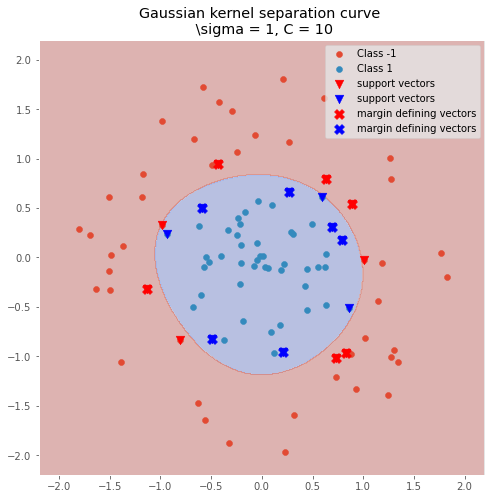

In [20]:
'''
Using the gaussian kernel of the previously generated data with circularly symetric random generators
'''

'''
We apply the phi map to our data set and compute the beta_phi and b_phi values
'''

x_trans = np.sum(np.power(x,2),axis = 1)
phi = np.transpose(np.stack([x[...,0],x[...,1],x_trans]))

beta_phi,b_phi = SMO_kernel(x,y,10,gaussian)

'''
The rest of the code is the same as before, just using the definitions involving the kernel this time.
'''

xx2, yy2 = np.meshgrid(np.arange(-2.2, 2.2, .01),
                     np.arange(-2.2, 2.2, .01))

mesh = np.c_[xx2.ravel(), yy2.ravel()]
M = []

for m in mesh:
    M.append(np.sum(np.multiply(beta_phi,np.multiply(y,gaussian(m,x)))) + b_phi > 0 )


mesh = np.array(M).reshape(xx2.shape)

support_vectors_r = x[int(len(x)/2):][beta_phi[int(len(x)/2):] > 0]
support_vectors_b = x[:int(len(x)/2)][beta_phi[:int(len(x)/2)] > 0]

margin_r = x[int(len(x)/2):][np.logical_and(beta_phi[int(len(x)/2):] > 0,beta_phi[int(len(x)/2):] < 10)]
margin_b = x[:int(len(x)/2)][np.logical_and(beta_phi[:int(len(x)/2)] > 0,beta_phi[:int(len(x)/2)] < 10)]

plt.contourf(xx2, yy2, mesh, cmap=plt.cm.coolwarm, alpha=0.3)
plt.scatter(phi[...,0][int(len(y)/2):],phi[...,1][int(len(y)/2):],label = "Class -1")
plt.scatter(phi[...,0][:int(len(y)/2)],phi[...,1][:int(len(y)/2)],label = "Class 1")

plt.scatter(support_vectors_r[...,0],support_vectors_r[...,1],color = "r",marker = "v",s=75,label = "support vectors")
plt.scatter(support_vectors_b[...,0],support_vectors_b[...,1],color = "b",marker = "v",s=75,label = "support vectors")
plt.scatter(margin_r[...,0],margin_r[...,1],color = "r",marker = "X",s=100,label = "margin defining vectors")
plt.scatter(margin_b[...,0],margin_b[...,1],color = "b",marker = "X",s=100,label = "margin defining vectors")

    
plt.ylim([-2.2,2.2])
plt.xlim([-2.2,2.2])
plt.legend(loc = 1)
plt.grid(False)
plt.title("Gaussian kernel separation curve \n \sigma = 1, C = 10")
plt.show()


# Task 2.8

In [21]:
import os
import gzip
from urllib . request import urlretrieve
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix

In [22]:
'''
Downloading MNIST data set
'''

def download(filename , source ='http://yann.lecun.com/exdb/mnist/'):
    print (" Downloading %s" % filename )
    urlretrieve(source + filename, filename)

def load_mnist_images(filename):
    if not os.path.exists(filename):
        download(filename)
    with gzip.open(filename , 'rb') as f:
        data = np.frombuffer(f.read() , np.uint8 , offset=16)
    data = data.reshape(-1, 28, 28)
    return data/np.float32 (256)
              
def load_mnist_labels(filename):
    if not os.path.exists(filename):
        download(filename)
    with gzip.open(filename, 'rb') as f:
        data = np.frombuffer(f.read (), np.uint8 , offset=8)
    return data
             
X_train = load_mnist_images('train-images-idx3-ubyte.gz')
y_train = load_mnist_labels('train-labels-idx1-ubyte.gz')
X_test = load_mnist_images('t10k-images-idx3-ubyte.gz')
y_test = load_mnist_labels('t10k-labels-idx1-ubyte.gz')

# a)

In [23]:
'''
Picking 500 random entries from the MNIST data set
'''

index = np.random.choice(len(X_train),500)
X_subset = X_train[index]
Y_subset = y_train[index]

'''
We transform the images into 1d arrays in order to be able to fit the GridSearchCV function
'''

nsamples, nx, ny = X_subset.shape
d2_train_dataset = X_subset.reshape((nsamples,nx*ny))

In [24]:
'''
Using sklearn to tune hyperparameters
'''

svc = svm.SVC()

'''
Selecting the parameters we want to try out and storing them in the dictionaty "parameters", defining "clf"
as the GridSearchCV sklearn function and fitting
'''
parameters = {'C':[1, 10, 100],'gamma': [0.1,0.01,0.001]}
clf = GridSearchCV(svc, parameters,cv = 5)
clf.fit(d2_train_dataset, Y_subset)

'''
Selectign the best result and storing it on "best"
'''

best = np.argmax(clf.cv_results_['mean_test_score'])
best = clf.cv_results_['params'][best]

# b)

In [25]:
'''
Making a multiclass SVM with the best hyperparameters we found
'''

clf = svm.SVC(C = best['C'], gamma = best['gamma'],decision_function_shape='ovo')

'''
Selecting 2000 samples from the MNIST data set to train the classifier
'''
index = np.random.choice(len(X_train),2000)
X_subset = X_train[index]
Y_subset = y_train[index]


'''
Preprocessing the images so we can fit the classifier and fitting it
'''
nsamples, nx, ny = X_subset.shape
d2_train_dataset = X_subset.reshape((nsamples,nx*ny))

clf.fit(d2_train_dataset, Y_subset)

'''
Taking the test data set and predicting the classification
'''

nsamples, nx, ny = X_test.shape
d2_test = X_test.reshape((nsamples,nx*ny))

classification = clf.predict(d2_test)

The accuracy of the SVM is  0.9383


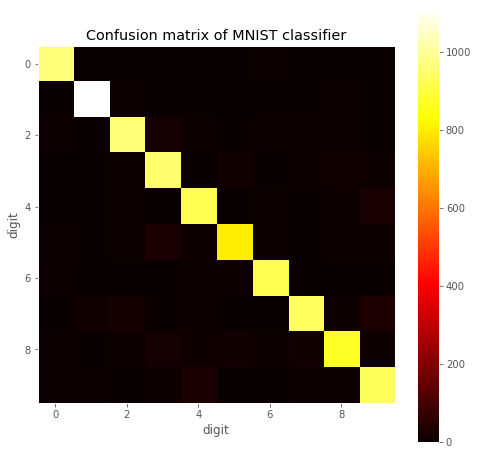

In [26]:
'''
Using sklearn to compute the confusion matrix and plotting it out as a heatmap for easier visualization.
Computing accuracy as well
'''

M = confusion_matrix(y_test,classification)
print("The accuracy of the SVM is ",np.trace(M)/np.sum(M))
plt.figure()
plt.title('Confusion matrix of MNIST classifier')
plt.xlabel('digit')
plt.ylabel('digit')
plt.imshow(M,cmap='hot')
plt.grid(False)
plt.colorbar()
plt.show()

<h5> In theory, since we approximately picked 50 samples of each digit to compute the hyperparameters, fitting hyperparameters and fitting the model with different data sets should not have such a big repercusion, but there is always the possibility of a misrepresentation of one class due to the randomness of the selecting system.  </h5>